<h1 style="background-color:skyblue;font-family:sans-serif;font-size:320%;text-align:center">This Is Why Your Jokes Aren't Funny</h1>

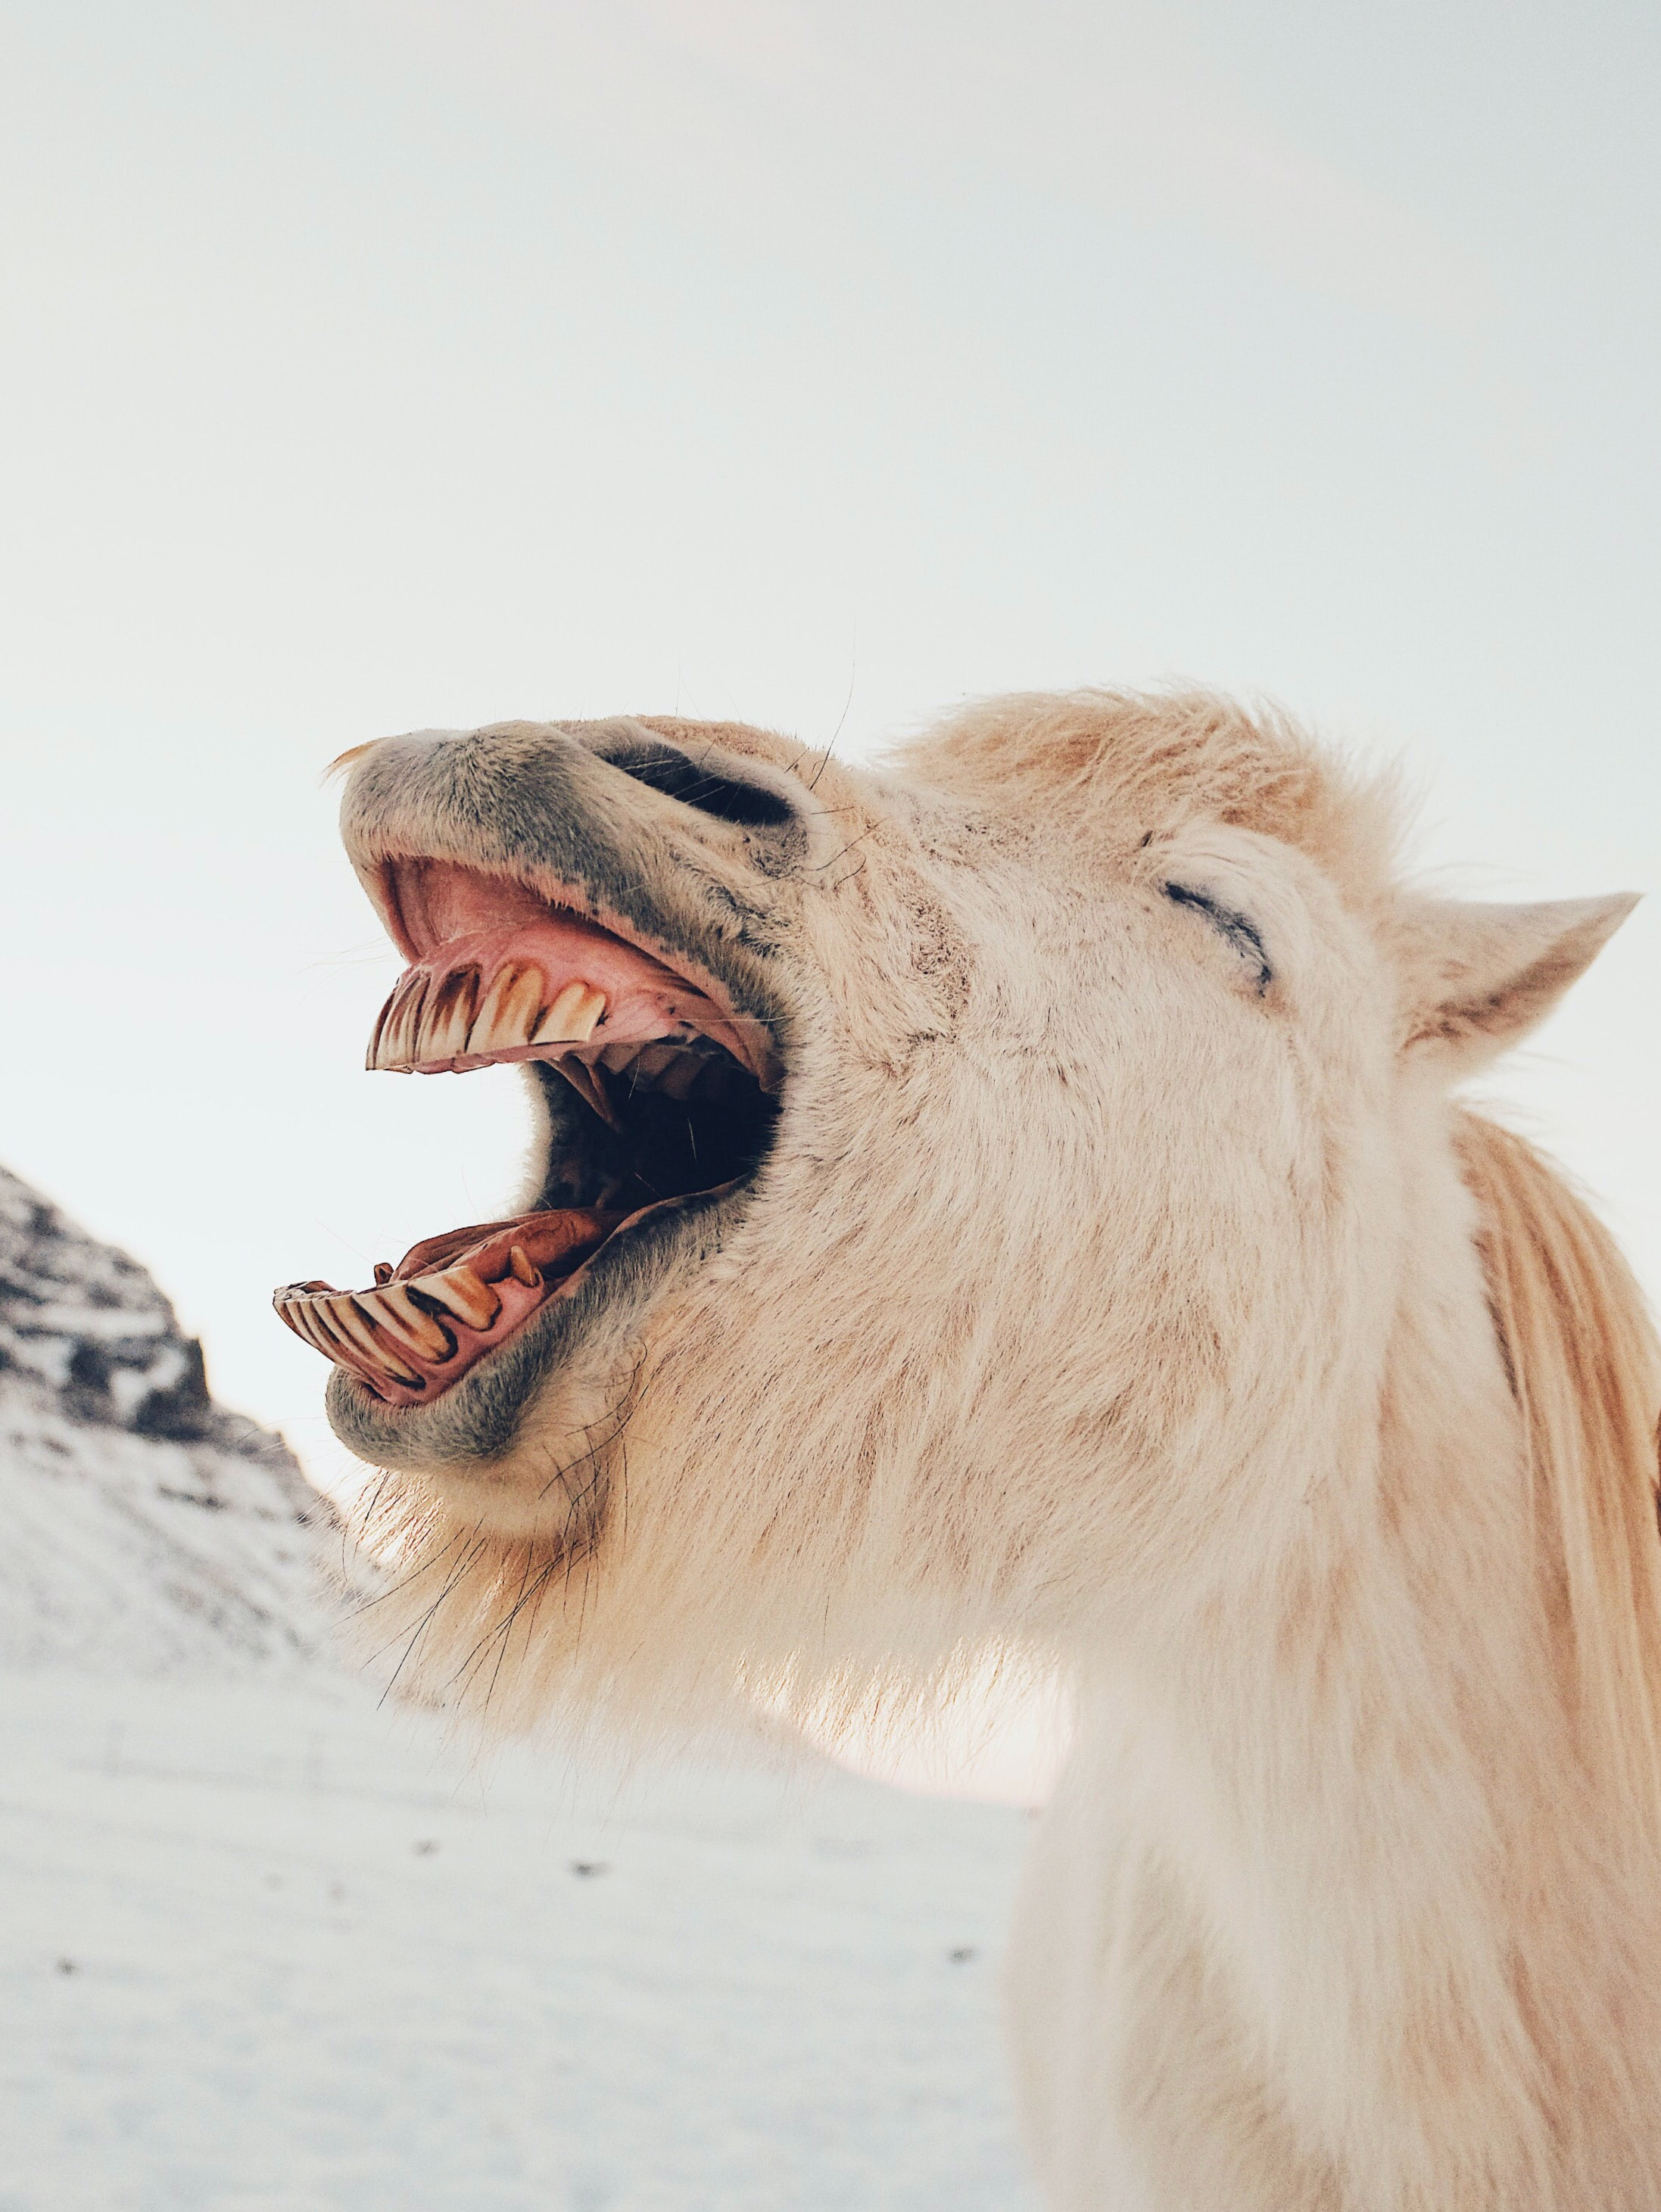

In [1]:
from IPython.display import Image
import os
Image("../input/laughing/dan-cook-MCauAnBJeig-unsplash.jpg")

<h2 style="background-color:skyblue;font-family:sans-serif;font-size:300%;text-align:center">Table Of Content</h2>

* [1. Business Understanding](#1)
* [2. Data Understanding](#2)
* [3. Data Preparation](#3)    
* [4. Data Analysis](#4) 
    * [4.1 Which words make a good joke?](#4.1)
    * [4.2 Which words make a bad joke?](#4.2)
    * [4.3 How long should a good joke be?](#4.3)
    * [4.4 Are there jokes everyone likes?](#4.4)
* [5. The Best, the Worst and the Most Controversial Joke](#5) 
* [6. Evaluation](#6) 


<a id="1"></a>
<h2 style="background-color:skyblue;font-family:sans-serif;font-size:300%;text-align:center">Business Understanding</h2>

With this data analysis the following questions will be answered:

    Which words make a good joke?
    Which words make a bad joke?
    How long should a good joke be?
    Are there jokes everyone likes?
    
    
The underlying data:
Jester is an online joke recommender system developed by Ken Goldberg and the team at UC Berkeley. Users are presented jokes through an HTML client interface and allowed to rate jokes. Once a user rates all jokes in the gauge set, the system recommends new jokes to the user. The dataset contains over 1.7 million continuous ratings (-10.00 to +10.00) of 150 jokes from 59,132 users. The dataset is collected between November 2006 - May 2009.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

from wordcloud import WordCloud, STOPWORDS
from scipy import optimize

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/laughing/dan-cook-MCauAnBJeig-unsplash.jpg
/kaggle/input/jester-17m-jokes-ratings-dataset/jester_items.csv
/kaggle/input/jester-17m-jokes-ratings-dataset/jester_ratings.csv


In [3]:
items = pd.read_csv("/kaggle/input/jester-17m-jokes-ratings-dataset/jester_items.csv")
ratings = pd.read_csv("/kaggle/input/jester-17m-jokes-ratings-dataset/jester_ratings.csv")

<a id="2"></a>
<h2 style="background-color:skyblue;font-family:sans-serif;font-size:300%;text-align:center">Data Understanding</h2>

In [5]:
## Exploration of items

In [6]:
items.shape

(150, 2)

In [7]:
items.head()

,jokeId,jokeText
0,1,"A man visits the doctor. The doctor says ""I ha..."
1,2,This couple had an excellent relationship goin...
2,3,Q. What's 200 feet long and has 4 teeth? \n\nA...
3,4,Q. What's the difference between a man and a t...
4,5,Q.\tWhat's O. J. Simpson's Internet address? \...


In [8]:
items.describe()

,jokeId
count,150.000000
mean,75.500000
std,43.445368
min,1.000000
25%,38.250000
50%,75.500000
75%,112.750000
max,150.000000


In [9]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   jokeId    150 non-null    int64 
 1   jokeText  150 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


In [10]:
# Are there any duplicates in the data?

items.duplicated().sum()


# conclusion: No

0

In [11]:
items["length"] = items["jokeText"].str.len()

In [12]:
## Exploration of Ratings

In [13]:
ratings.shape

(1761439, 3)

In [14]:
ratings

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875
...,...,...,...
1761434,63978,57,-8.531
1761435,63978,24,-9.062
1761436,63978,124,-9.031
1761437,63978,58,-8.656


In [15]:
ratings.describe()

# The mean rating is 1.619 and its standard deviation 5.303.

,userId,jokeId,rating
count,1.761439e+06,1.761439e+06,1.761439e+06
mean,3.272322e+04,7.071133e+01,1.618602e+00
std,1.828011e+04,4.600790e+01,5.302608e+00
min,1.000000e+00,5.000000e+00,-1.000000e+01
25%,1.720200e+04,2.100000e+01,-2.031000e+00
50%,3.480800e+04,6.900000e+01,2.219000e+00
75%,4.730600e+04,1.120000e+02,5.719000e+00
max,6.397800e+04,1.500000e+02,1.000000e+01


In [16]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761439 entries, 0 to 1761438
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   userId  int64  
 1   jokeId  int64  
 2   rating  float64
dtypes: float64(1), int64(2)
memory usage: 40.3 MB


In [17]:
# Are there any duplicates in the data?

ratings.duplicated().sum()


# conclusion: No

0

Text(0.5, 1.0, 'Distribution of the Rating')

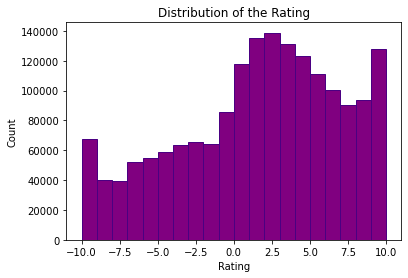

In [18]:
# Distribution of the ratings

ratings["rating"].hist(range=(-10,10), bins=20, color="purple", edgecolor="indigo", linewidth=1)
plt.grid(False)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of the Rating")

<a id="3"></a>
<h2 style="background-color:skyblue;font-family:sans-serif;font-size:300%;text-align:center">Data preparation</h2>

In [19]:
# Normalization, Tokenization, Stopwords removal, Verb lemmatization

items["prepared_jokeText"] = items["jokeText"].apply(lambda x: re.sub(r"[^a-zA-Z0-9]", " ", x.lower()))
items["prepared_jokeText"] = items["prepared_jokeText"].apply(lambda x: word_tokenize(x))
items["prepared_jokeText"] = [[w for w in words if w not in stopwords.words("english")] 
                              for words in items["prepared_jokeText"]]
items["prepared_jokeText"] = [[WordNetLemmatizer().lemmatize(w, pos="v") for w in words] 
                              for words in items["prepared_jokeText"]]
items["prepared_jokeText"]

0      [man, visit, doctor, doctor, say, bad, news, c...
1      [couple, excellent, relationship, go, one, day...
2      [q, 200, feet, long, 4, teeth, front, row, wil...
3      [q, difference, man, toilet, toilet, follow, a...
4      [q, j, simpson, internet, address, slash, slas...
                             ...                        
145    [america, 8, 00, welcome, work, 12, 00, lunch,...
146    [day, big, sale, rumor, sale, advertise, local...
147    [recently, teacher, garbage, collector, lawyer...
148    [little, girl, ask, father, daddy, fairy, tale...
149    [interview, david, letterman, carter, pass, al...
Name: prepared_jokeText, Length: 150, dtype: object

In [20]:
# Merge of the two data sets without the user information. Just mean ratings per joke.
# Advantage: The jokes do not have to be repeated per user.

jokes_mean_rating = items.merge(ratings.groupby(["jokeId"]).mean().rating , on='jokeId', how='inner')

In [21]:
jokes_mean_rating

,jokeId,jokeText,length,prepared_jokeText,rating
0,5,Q.\tWhat's O. J. Simpson's Internet address? \...,95,"[q, j, simpson, internet, address, slash, slas...",-1.756331
1,7,How many feminists does it take to screw in a ...,76,"[many, feminists, take, screw, light, bulb, fu...",-1.809230
2,8,Q. Did you hear about the dyslexic devil worsh...,84,"[q, hear, dyslexic, devil, worshiper, sell, so...",-0.672010
3,13,They asked the Japanese visitor if they have e...,101,"[ask, japanese, visitor, elections, country, e...",-0.590224
4,15,Q: What did the blind person say when given s...,88,"[q, blind, person, say, give, matzah, hell, wr...",-1.377098
...,...,...,...,...,...
135,146,America: 8:00 - Welcome to work! 12:00 - Lunch...,311,"[america, 8, 00, welcome, work, 12, 00, lunch,...",0.178280
136,147,It was the day of the big sale. Rumors of the ...,592,"[day, big, sale, rumor, sale, advertise, local...",1.783395
137,148,"Recently a teacher, a garbage collector, and a...",795,"[recently, teacher, garbage, collector, lawyer...",3.061760
138,149,"A little girl asked her father, ""Daddy? Do all...",187,"[little, girl, ask, father, daddy, fairy, tale...",2.399796


In [37]:
best_rated = jokes_mean_rating[jokes_mean_rating["rating"] > 3]
worst_rated = jokes_mean_rating[jokes_mean_rating["rating"] < -1]

18     [old, scotsmen, sit, younger, scottish, gentle...
21     [man, arrive, gate, heaven, st, peter, ask, re...
24     [explorer, deepest, amazon, suddenly, find, su...
38     [three, engineer, students, gather, together, ...
39     [guy, go, confession, say, priest, father, 80,...
42     [one, sunday, morning, william, burst, live, r...
51     [group, managers, give, assignment, measure, h...
57     [man, pilot, hot, air, balloon, discover, wand...
58     [guy, wife, ask, honey, die, would, remarry, r...
61     [first, day, college, dean, address, students,...
78     [radio, conversation, us, naval, ship, canadia...
93     [pre, med, student, take, difficult, class, ph...
94     [couple, hunters, woods, deep, south, one, fal...
95     [engineer, die, report, pearly, gate, st, pete...
97     [man, approach, beautiful, woman, large, super...
103    [sherlock, holmes, dr, watson, go, camp, trip,...
106    [man, join, big, corporate, empire, trainee, f...
115    [briton, frenchman, russ

In [23]:
def word_list(joke_data):
    """
    Description: This function reformats the joke texts of the input dataframe into a list of words.
    
    Arguments:
        joke_data: a dataframe with already tokenized joke texts in a column called "prepared_jokeText"
    
    Returns:
        list_of_words: list of words of all joke texts
    """
    
    list_of_words = []
    
    for list in joke_data["prepared_jokeText"]:
        for word in list:
            list_of_words.append(word)
    return list_of_words

<a id="4"></a>
<h2 style="background-color:skyblue;font-family:sans-serif;font-size:300%;text-align:center">Data Analysis</h2>

<a id="4.1"></a>
<h3 style="background-color:skyblue;font-family:sans-serif;font-size:200%;text-align:center">Which words make a good joke?</h3>

Good jokes often contain words like ‘man‘, ‘go‘, ‘say‘, ‘tell‘. So a storytelling seems to be an important part of a good joke.

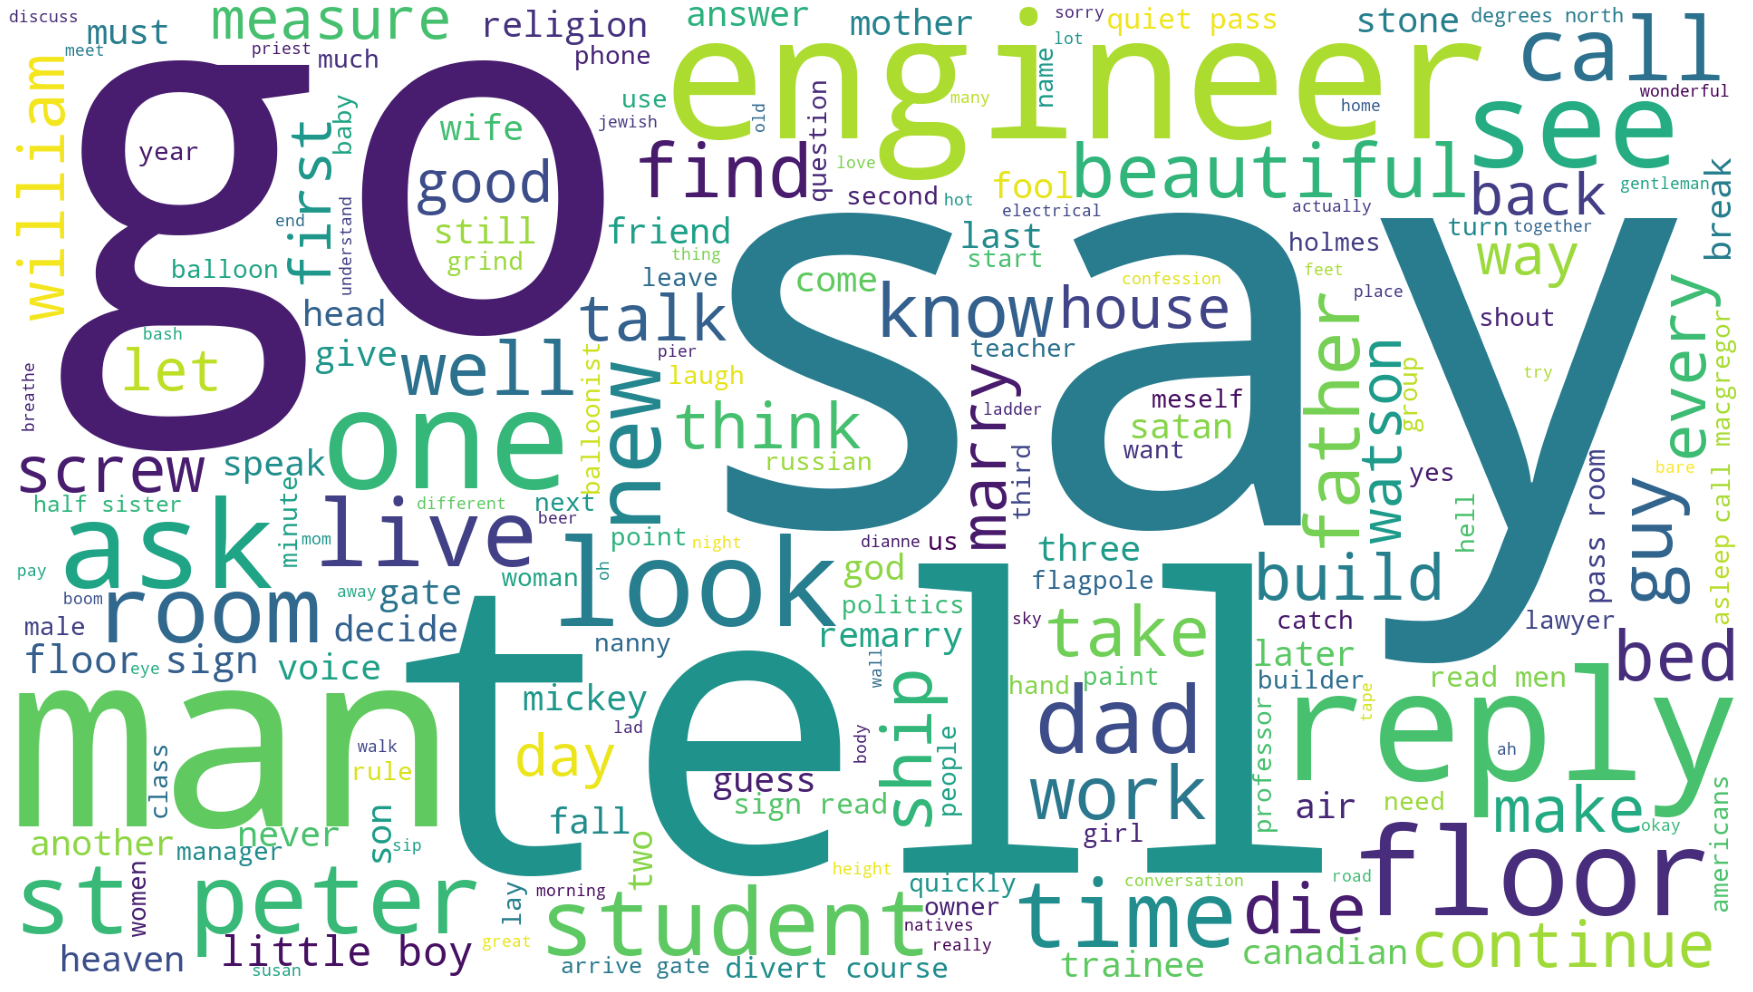

In [24]:
text = ' '.join([word for word in word_list(best_rated)])
cloud = WordCloud(background_color='white', width=1920, height=1080).generate(text)
plt.figure(figsize=(32, 18))
plt.axis("off")
plt.imshow(cloud)

<a id="4.2"></a>
<h3 style="background-color:skyblue;font-family:sans-serif;font-size:200%;text-align:center">Which words make a bad joke?</h3>

The word frequency of bad jokes reveals that ‘knock knock’ and ‘lightbulb’ jokes are out. You should avoid those.

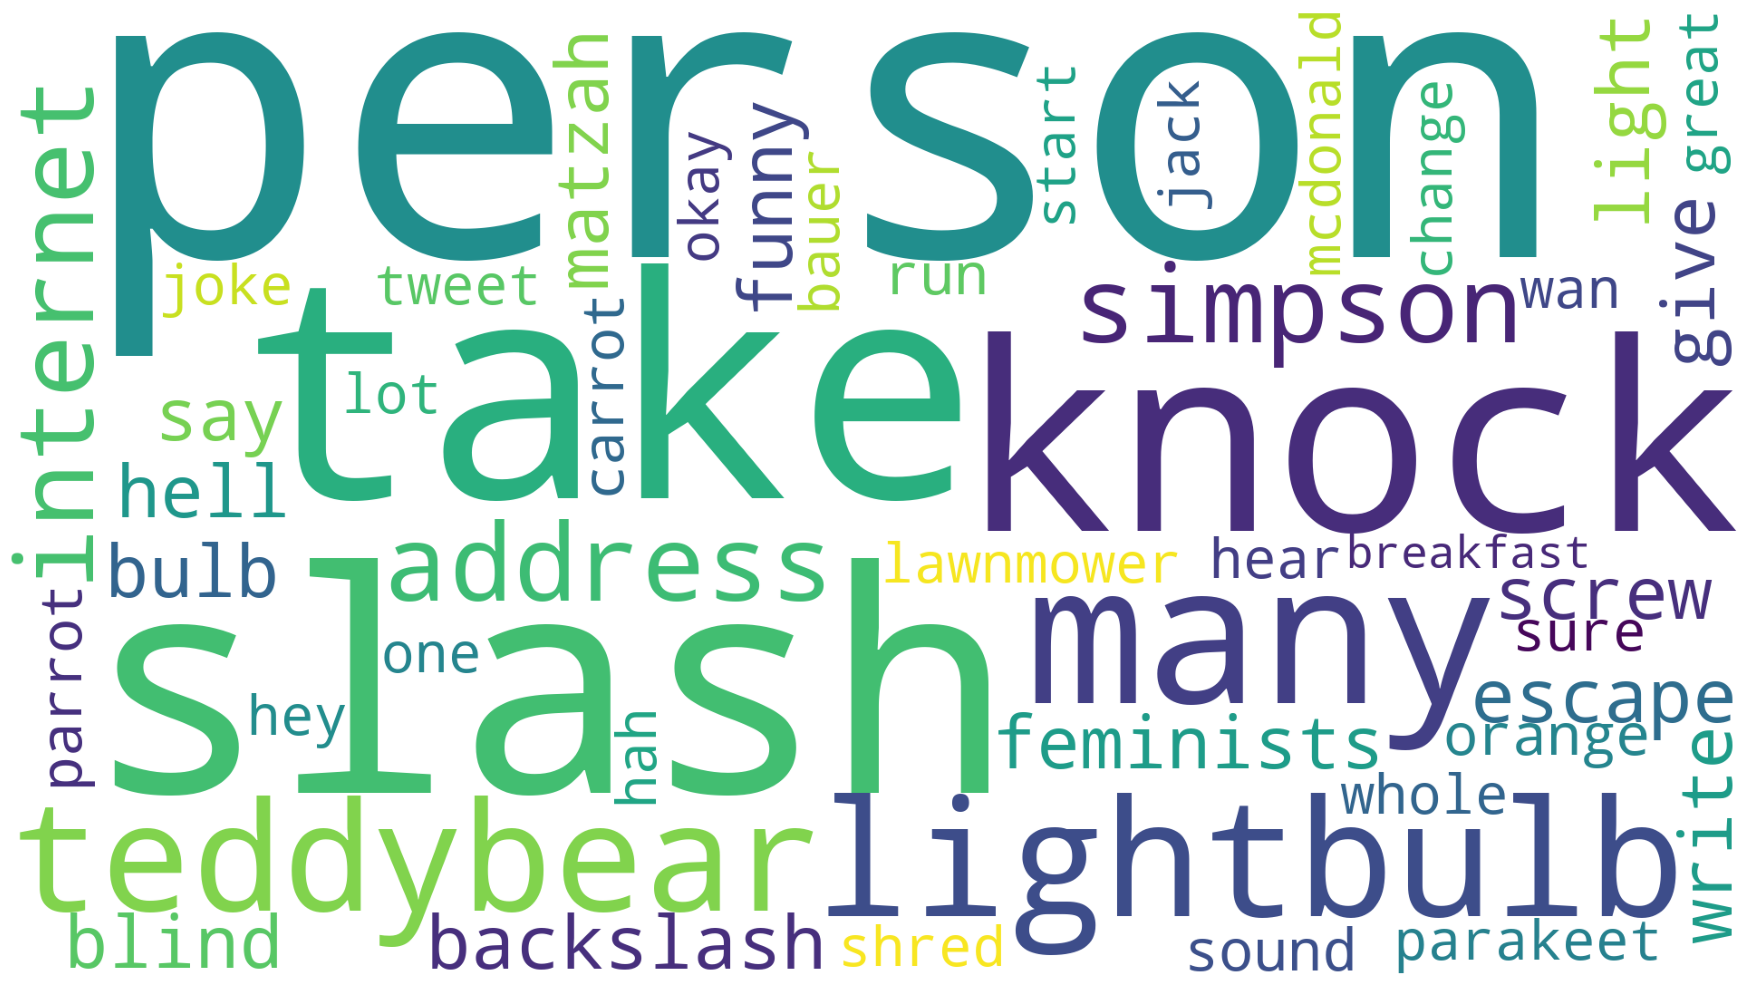

In [25]:
stopwords = set(STOPWORDS)
stopwords.update(["q", "na", "j"])

text = ' '.join([word for word in word_list(worst_rated)])
cloud = WordCloud(stopwords=stopwords, background_color='white', width=1920, height=1080).generate(text)
plt.figure(figsize=(32, 18))
plt.axis('off')
plt.imshow(cloud)
plt.savefig('worst_jokes_wordcloud.png')

<a id="4.3"></a>
<h3 style="background-color:skyblue;font-family:sans-serif;font-size:200%;text-align:center">How long should a good joke be?</h3>

You keep your jokes short so that your listeners won’t be bored? That’s not the best idea! The scatterplot left bottom shows that jokes with at least 600 characters are funnier.

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


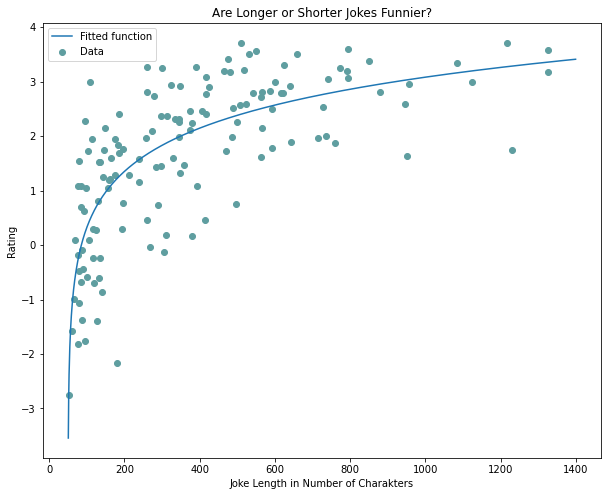

In [26]:
def fitfunc (x, a, b, c, d):
    """
    Description: Fits a logarithmic curve to data points.
    
    Arguments:
       x: variable 
       a: parameter of the function
       b: parameter of the function
       c: parameter of the function
       d: parameter of the function
    
    Returns:
        A logarithmic function
    """
    return a + b * np.log(c * x + d)


params, params_covariance = optimize.curve_fit(fitfunc,jokes_mean_rating["length"], jokes_mean_rating["rating"])
x_values = np.arange(0, 1400, 1)
plt.figure(figsize=(10,8))
plt.scatter(jokes_mean_rating["length"], jokes_mean_rating["rating"], label="Data", color="cadetblue")
plt.plot(x_values,fitfunc(x_values, params[0], params[1], params[2], params[3]),
         label='Fitted function')
plt.legend(loc='best')
plt.xlabel("Joke Length in Number of Charakters")
plt.ylabel("Rating")
plt.title("Are Longer or Shorter Jokes Funnier?")

plt.show()

Though 81% of the jokes are shorter.

In [27]:
(jokes_mean_rating["length"] < 600).sum()/len(jokes_mean_rating["length"])

0.8071428571428572

Text(0.5, 1.0, 'Distribution of the Text Length')

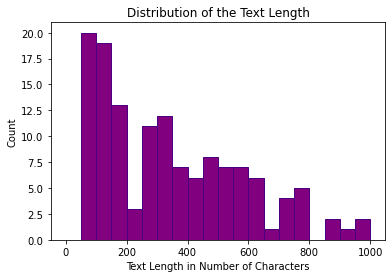

In [28]:
jokes_mean_rating["length"].hist(range=(0,1000), bins=20, color="purple", edgecolor="indigo", linewidth=1)
plt.grid(False)
plt.xlabel("Text Length in Number of Characters")
plt.ylabel("Count")
plt.title("Distribution of the Text Length")

<a id="4.4"></a>
<h3 style="background-color:skyblue;font-family:sans-serif;font-size:200%;text-align:center">Are there jokes everyone likes?</h3>

Finally the mean ratings for jokes only crowd in the middle between -2.7 and 3.7. So jokes that are funny to everyone just do not exist. Nor jokes that everyone regards as terrible.

Text(0.5, 1.0, 'Distribution of the Mean Rating per Joke')

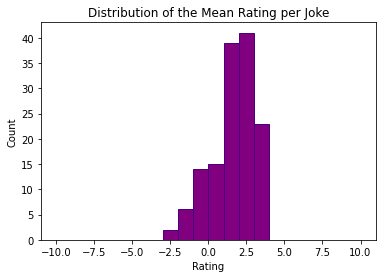

In [29]:
# Distribution of the mean ratings

jokes_mean_rating["rating"].hist(range=(-10,10), bins=20, color="purple", edgecolor="indigo", linewidth=1)
plt.grid(False)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of the Mean Rating per Joke")

Text(0.5, 1.0, 'Distribution of the Rating per person')

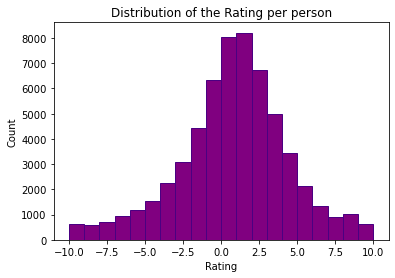

In [30]:
# Are there many people who rate very high and others that rate very low? 
# Or does the mayority vote relatively neutral?

ratings_per_person = ratings.groupby(["userId"]).mean().rating  
ratings_per_person.hist(range=(-10,10), bins=20, color="purple", edgecolor="indigo", linewidth=1)
plt.grid(False)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of the Rating per person")

<a id="5"></a>
<h2 style="background-color:skyblue;font-family:sans-serif;font-size:300%;text-align:center">The Best, the Worst and the Most Controversial Joke</h2>

The Best Rated Joke

In [31]:
# Best rated joke
best_joke = jokes_mean_rating[jokes_mean_rating["rating"] == jokes_mean_rating["rating"].max()]
best_joke.iloc[0].jokeText

'One Sunday morning William burst into the living room and said,\n"Dad! Mom! I have some great news for you! I am getting married\nto the most beautiful girl in town. She lives a block away and\nher name is Susan."\nAfter dinner, William\'s dad took him aside. "Son, I have to talk\nwith you. Your mother and I have been married 30 years.. She\'s a\nwonderful wife but she has never offered much excitement in the\nbedroom, so I used to fool around with women a lot. Susan is\nactually your half-sister, and I\'m afraid you can\'t marry her."\nWilliam was heart-broken. After eight months he eventually\nstarted dating girls again. A year later he came home and very\nproudly announced, "Dianne said yes! We\'re getting married in\nJune."\nAgain his father insisted on another private conversation and\nbroke the sad news. "Dianne is your half-sister too, William. I\'m\nawfully sorry about this."\nWilliam was furious! He finally decided to go to his mother with\nthe news.\n"Dad has done so much ha

The Worst Rated Joke

In [32]:
# Here I want to look at more than one joke to see relationships with 
# the most controversial jokes later.

worst_jokes = jokes_mean_rating.sort_values("rating")
worst_jokes

,jokeId,jokeText,length,prepared_jokeText,rating
130,141,Jack Bauer can get McDonald's breakfast after ...,52,"[jack, bauer, get, mcdonald, breakfast, 10, 30]",-2.749574
113,124,"Person 1: Hey, wanna hear a great knock-knock ...",181,"[person, 1, hey, wan, na, hear, great, knock, ...",-2.163482
1,7,How many feminists does it take to screw in a ...,76,"[many, feminists, take, screw, light, bulb, fu...",-1.809230
0,5,Q.\tWhat's O. J. Simpson's Internet address? \...,95,"[q, j, simpson, internet, address, slash, slas...",-1.756331
5,16,Q. What is orange and sounds like a parrot? \...,60,"[q, orange, sound, like, parrot, carrot]",-1.587044
...,...,...,...,...,...
24,35,An explorer in the deepest Amazon suddenly fin...,549,"[explorer, deepest, amazon, suddenly, find, su...",3.560305
118,129,A group of girlfriends is on vacation when the...,1325,"[group, girlfriends, vacation, see, 5, story, ...",3.583496
78,89,A radio conversation of a US naval \nship with...,795,"[radio, conversation, us, naval, ship, canadia...",3.606506
94,105,A couple of hunters are out in the woods in th...,510,"[couple, hunters, woods, deep, south, one, fal...",3.711223


In [33]:
worst_jokes.iloc[0].jokeText

"Jack Bauer can get McDonald's breakfast after 10:30."

The Most Controversal (And Second Worst) Joke

In [34]:
# most controversial

jokes_mean_std = ratings.groupby(["jokeId"]).std().rating 
jokes_mean_std.sort_values(ascending=False)

jokeId
124    6.083010
140    6.082668
58     6.079473
57     5.951290
123    5.903458
         ...   
134    4.364110
72     4.356456
108    4.347951
105    4.323487
104    4.283718
Name: rating, Length: 140, dtype: float64

In [35]:
# This one is both: second worst and most controversial

most_controversial_joke = jokes_mean_rating[jokes_mean_rating["jokeId"] == 124]
most_controversial_joke.iloc[0].jokeText

"Person 1: Hey, wanna hear a great knock-knock joke? Person 2: Sure, What is it? Person 1: Okay, you start. Person 2: Knock-knock. Person 1: Who's there? Person 2: ... Person 1: Hah!"

<a id="6"></a>
<h2 style="background-color:skyblue;font-family:sans-serif;font-size:300%;text-align:center">Evaluation</h2>

Jokes that are funny to everyone just do not exist. Nor jokes that everyone regards as terrible. The second worst rated joke has also been the most controversial one. 

Whether a joke is funny or not remains very subjective. So the best you can do is respond to the preferences of your listeners.

A first clue is to tell a story in the joke with more than 600 characters.